<H2>Create face:label dictionary</H2>
    
The aim of this notebook is to create a set of labelled data to train our ML model (most likely convNet)

In [27]:
import os
import cv2
import spacy
import operator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import loadmat
%matplotlib inline

In [2]:
def convert_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
nlp = spacy.load('en')
caption_file = '../data/raw/labeledCaptions.mat'
labels = loadmat(caption_file)
all_captions = labels['captions']
haarCascade = '../opencv-3.3.1/data/haarcascades/haarcascade_frontalface_alt.xml'
faceDetector = cv2.CascadeClassifier(haarCascade)

Firstly, we need to get rid of the photographers' names from our captions

In [6]:
def names_from_captions(details):
    cleaned_details = []
    for i in range(np.shape(details)[1]):
        cleaned_details.append(str(details[:,i].tolist()).split('dtype')[0][:-30])
    #Create dictionary with img-name:face-name format
    cleaned_captions={}
    for i in range(np.shape(cleaned_details)[0]):
        cap = str(cleaned_details[i])
        doc = nlp(str(cap))
        people = []
        dates=[]
        for ent in doc.ents:
            if ent.label_=='PERSON' and len(ent.text) > 2:
                name = ent.text
                if name[0]=="'" or name[0]=="\"":
                    name=name[1:]
                if name[-1]=="'" or name[-1]=="\"":
                    name=name[-1]
                if not name.startswith("array") and len(name)>2:
                    people.append(name)
        cap2 = str(details[:,i])
        img_name = cap2.split('.jpg')[0].split('array([\'20')[1]
        if img_name[:2]=='03'and img_name[3:5] in ['01','02','03']:
            cleaned_captions[str(img_name)] = np.unique(people)
    return cleaned_captions

In [7]:
img_dict = names_from_captions(all_captions)

In [8]:
def face_positions(cleaned_captions):
    correctly_detected_clean = {}
    correct_positions_clean = {}
    for key, value in cleaned_captions.items():
        people = value
        img_path = "../data/raw/%s.jpg"%key[3:]
        img = cv2.imread(img_path)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceDetector.detectMultiScale(img_grey, 1.3, 5)
        posns=[]
        for x,y,w,h in faces:
            posns.append([x,y,w,h])
            #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        ground_truth_names =  [name for name in value if str(" ") in name] 
        if len(ground_truth_names)==len(faces):
            correctly_detected_clean[key] = value
            correct_positions_clean[key] = posns
    return correct_positions_clean

In [9]:
posn_dict = face_positions(img_dict)

In [10]:
names = img_dict['03/03/02/img_428']
posns = posn_dict['03/03/02/img_428']
img = cv2.imread('../data/raw/03/02/img_428.jpg')
print(names)
print(posns)

['Daldry' 'Julianne Moore' 'Stephen Daldry']
[[119, 115, 125, 125], [20, 38, 144, 144]]


['Daldry' 'Julianne Moore' 'Stephen Daldry']


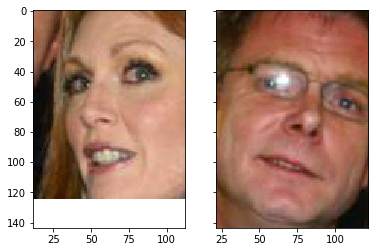

In [19]:
def face_match_name(img_path, plot=False):
    names = img_dict[img_path]
    posns = posn_dict[img_path]
    faces = []
    img = cv2.imread('../data/raw/%s.jpg'%img_path[3:])
    if plot:
        fig, axes = plt.subplots(1, len(posns), sharey=True)
    for i in range(len(posns)):
        x,y,w,h = posns[i][0],posns[i][1],posns[i][2],posns[i][3]
        face_extract = img[y:y+h, x:x+h]
        if plot:
            if len(posns)>1:
                axes[i].imshow(convert_to_rgb(face_extract))
            else:
                axes.imshow(convert_to_rgb(face_extract))
        #print(names[i])
        faces.append(face_extract)
    return names, faces

names1, faces1 = face_match_name('03/03/02/img_428', plot=True)
print(names1)

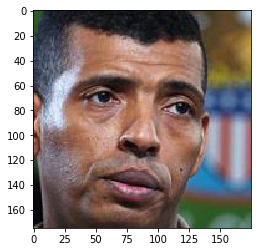

In [12]:
names2, faces2 = face_match_name('03/03/31/img_1082', plot=True)
print(names2)

['> Regan Upshaw']


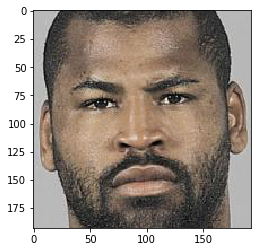

In [15]:
names3, faces3 = face_match_name('03/01/23/img_725', plot=True)
print(names3)

Now we have a way to extract faces and labels from an image, we want to store the face examples for each name. In many cases there will be more than one image per name.

In [20]:
correct_extracts = {}
for key, value in img_dict.items():
    try:
        names, faces = face_match_name(key)
        #print('shape faces:', np.shape(faces))
    except:
        continue
    for i in range(len(faces)):
        #print('shape faces:', np.shape(faces[i]))
        if not names[i] in correct_extracts:
            correct_extracts[names[i]]= [faces[i]]
        else:
            #print("%s has more than one entry"%names[i])
            correct_extracts[names[i]].append(faces[i])
            #print("New shape of this entry:", np.shape(correct_extracts[names[i]]))

In [26]:
print(len(correct_extracts['Norah Jones']))

10


In [23]:
with open('../data/processed/labelled_faces.txt', 'wb') as f:
    np.save(f, correct_extracts)

In [25]:
load_extr = np.load('../data/processed/labelled_faces.txt')
correct_extracts = dict(load_extr[()])
print(len(correct_extracts['Norah Jones']))

10


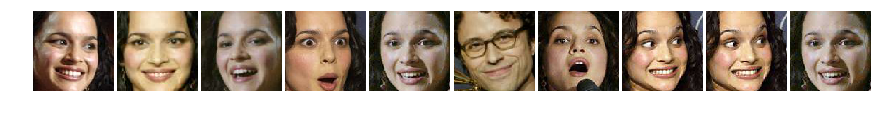

In [41]:
def celeb_test(celeb):

    N = len(correct_extracts[celeb])
    cols = 10
    rows = int(np.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols, wspace=0.05, hspace=0.05)
    fig = plt.figure(figsize=(15, 5))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        ax.imshow(convert_to_rgb(correct_extracts[celeb][n]))
        ax.axis('off')
    return

celeb_test('Norah Jones')

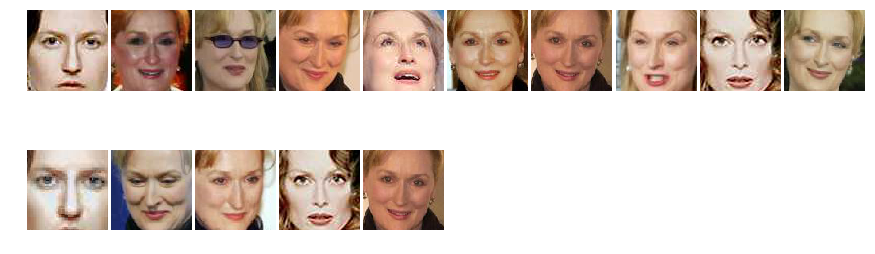

In [46]:
celeb_test('Meryl Streep')

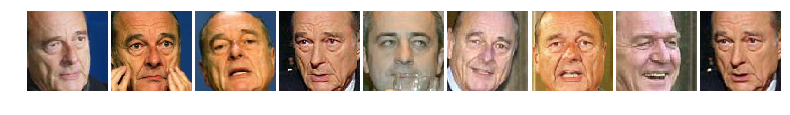

In [47]:
celeb_test('Jacques Chirac')

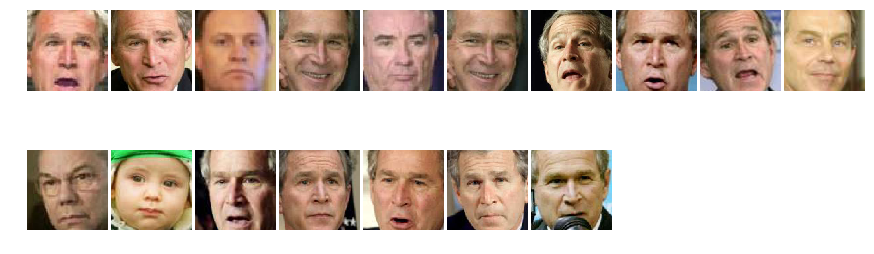

In [48]:
celeb_test('George W. Bush')

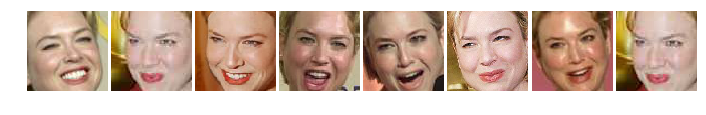

In [49]:
celeb_test('Renee Zellweger')

56 of the 68 (82%) images above are correctly labelled. Clearly some faces are going to be better training examples than others. We can neglect names with fewer than 3 examples.

In [50]:
count_extracts = {}
for key, value in correct_extracts.items():
    print(key, len(value))
    count_extracts[key] = len(value)

Actor 71
Henri Proglio 2
Bush 181
Imad Khadduri 1
Chavez 20
Christie Whitman 1
Roger Moore 2
> Cameron Diaz 2
Kidman 8
Meryl Streep 15
Jacques Chirac 9
Tom Ridge 10
Norah Jones 10
Colin Powell 72
George Robertson 8
> Carolyn Dawn Johnson 2
Michael Kostelnik 3
Mariucci 9
Lord Robertson 4
Kevin Spacey 2
2003on Capitol Hill 1
Cheney 1
Alexander Losyukov 4
Karin Viard 1
Daldry 2
Julianne Moore 10
Steve Mariucci 3
Anna Kournikova 2
Ron Dittemore 6
Dr Nizar Madani 1
Donald Rumsfeld 37
Laura Bush 3
Gideon Yago 1
Laura Elena Harring 4
Bren 4
Rob Marshall 3
Kuchma 5
Igor S 1
Pierre Pettigrew 1
Edward Norten 1
John Kerry 10
Kerry 1
> Craig David 1
Dexter Jackson 1
Alberto Fujimori 5
Kofi 3
Mark Everson 1
George Clooney 3
John P 2
Bill Graham 8
Hermann Maier 1
> Carson Palmer 1
Gerhard Schroeder 28
Abdullah Gul 21
Gul 2
John Manley 6
Berlinale 3
Ann Veneman 1
David Dewhurst 2
Perry 1
Peter Brabeck 2
> Gina Gershon 1
Polanski 5
Ebert 1
Harvey Wachsman 1
Ain Seppik 1
Derek Bond 1
Montesinos 2
Jack 

Jolie 1
Steve Alford 1
Chris Cooper 2
Cooper 1
A. Slepian 1
Barnett 1
D'Amico 1
Scott Rudin 2
John Lynch 1
Tom Brennan 1
Gerald Fitch 1
Dick Ebersol 1
Claudette Robinson 1
Mines 1
Rocco Mediate 1
Jan 26 1
Donald L. Evans 1
Joseph Deiss 1
>Castillo 1
> Hollings 1
Charles Rangel 1
Singer Ashante 1
Jennifer Aniston 2
Jean-Marc de La 1
Hoon 1
> Bill Gates 3
Silvo Berlusconi 1
Kevin Mitnick 1
Robert Parish 1
Tom Golisano 1
John 2
Charlie 1
Chen Shui-bian 1
Anneli Jaatteenmaki 1
Greenstock 2
Amram Mitzna 2
Arellan 1
Arnold Scott 1
O'Connor 1
Bates 2
Henry 1
Jake Plummer 1
Richard Gere 1
Bobby Goldwater 2
James Wolfensohn 1
Jason Kapono 1
Steve Lavin 1
Tassos Papadopoulos 1
Eichenlaub 1
Juan Luis Londono 2
Amr Moussa 1
John Edwards 1
Cristina Mojarro 2
Joe Oliver 1
Allen Iverson 1
Naomi Watts 1
David Barno 1
Farhi 1
Enrique Bolanos 1
E. Clay 1
Jimmy Kimmel 1
Carsten Reinhardt 1
Alfred Hitchock 1
Hedren 1
Kieu Chinh 1
> Ahmed 1
Roberto Benigni 2
Harrigan 1
Matt Doherty 1
> Bill Mauldin 1
Harry

In [51]:
count_names = {}
for key, val in count_extracts.items():
    if val>=3 and key!='Actor':
        if key[-1]=='<':
            key=key[:-1]
        if key[0]=='>':
            key=key[1:]
        count_names[key] = val

print(dict(sorted(count_names.items(), key=operator.itemgetter(1), reverse=True)))

{'Bush': 181, 'Colin Powell': 72, 'Donald Rumsfeld': 37, 'Gerhard Schroeder': 28, 'Abdullah Gul': 21, 'Ariel ': 21, 'Chavez': 20, 'Blair': 20, 'Chretien': 17, 'George W. Bush': 17, 'Meryl Streep': 15, 'Tony Blair': 15, 'John Negroponte': 15, 'Junichiro Koizumi': 13, 'Hugo Chavez': 13, 'Jack Straw': 12, 'Jones': 12, 'Jan': 12, 'Annan': 11, 'Jeremy Greenstock': 11, 'Blix': 11, 'Tom Ridge': 10, 'Norah Jones': 10, 'Julianne Moore': 10, 'John Kerry': 10, 'Hans Blix': 10, 'Jacques Chirac': 9, 'Mariucci': 9, 'Ricardo Lagos': 9, 'Catherine Zeta-': 9, 'Saddam Hussein': 9, 'Kidman': 8, 'George Robertson': 8, 'Bill Graham': 8, 'Jose Maria Aznar': 8, 'Renee Zellweger': 8, 'Igor Ivanov': 8, 'Jean Chretien': 8, 'Chirac': 8, 'Ashcroft': 8, 'Ron Dittemore': 6, 'John Manley': 6, 'Bill Callahan': 6, 'Kuchma': 5, 'Alberto Fujimori': 5, 'Polanski': 5, 'Carter': 5, 'Hamister': 5, 'Putin': 5, 'Bolton': 5, 'Ridge': 5, ' Ruth Morris': 5, 'Bill': 5, 'Kamal Kharrazi': 5, 'Arnett': 5, 'Michael Bloomberg': 5, 'Jo